In [1]:
import os
import sys
sys.path.append("../")

import pandas as pd
from datetime import datetime, date
import matplotlib.pyplot as plt
import numpy as np
from settings import PSO_DIR, PROCESSED_DATA_DIR, FIGURES_DIR
from src.features.file_helpers import create_dir
from src.visualization.helpers.matplotlib_style import load_plt_style
from src.visualization.constants import POSITION_COLOR_DICT

In [2]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [3]:
pso_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f'pso_all_players_power_vectors.csv'))
nelder_df = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, f'nelder-mead_all_players_power_vectors.csv'))

In [4]:
pso_df.loc[:, 'num_players'] = 1
pos_pso_df = pso_df.groupby('position').agg({
    'P-2': 'mean',
    'P-1': 'mean',
    'P0': 'mean',
    'P1': 'mean',
    'P2': 'mean',
    'stamina': 'mean',
    'num_players': 'count'
})
pos_pso_df.reset_index(inplace=True)
pos_pso_df

,position,P-2,P-1,P0,P1,P2,stamina,num_players
0,CB,526.313818,492.574930,615.966596,622.078709,585.681153,0.678025,5
1,FW,734.036841,721.516013,660.063197,686.716733,544.551345,0.506130,5
2,MF,561.561026,638.520869,691.331745,688.658225,679.331482,0.674532,5
3,WM,641.336545,434.360466,641.957472,580.603297,628.563463,0.687120,4


In [5]:
nelder_df.loc[:, 'num_players'] = 1
pos_nelder_df = nelder_df.groupby('position').agg({
    'P-2': 'mean',
    'P-1': 'mean',
    'P0': 'mean',
    'P1': 'mean',
    'P2': 'mean',   
    'stamina': 'mean',
    'num_players': 'count'
})
pos_nelder_df.reset_index(inplace=True)
pos_nelder_df

,position,P-2,P-1,P0,P1,P2,stamina,num_players
0,CB,580.091843,493.714074,616.578954,623.163683,587.113503,0.675710,5
1,FW,617.416191,721.516839,660.062223,686.717572,544.551327,0.506129,5
2,MF,681.001088,638.572497,691.420550,688.749861,679.416540,0.674308,5
3,WM,641.945168,434.730623,642.337070,580.942444,629.319657,0.686072,4


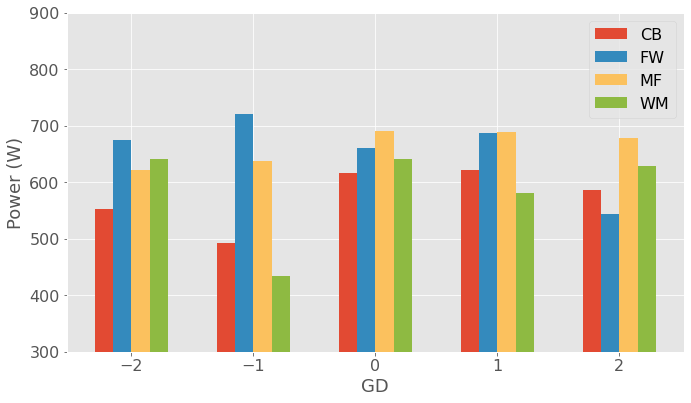

In [6]:
load_plt_style()
scores = ['P-2', 'P-1', 'P0', 'P1', 'P2']
width = 0.15

figsize = (10, 6)
plt.figure(figsize=figsize)

offset_default = np.arange(-1.5, 1.6, 1)
offset_default *= width
# -2 ... 2
positions = pos_pso_df.position.unique()
for i, position in enumerate(positions):
    ps_df = pos_pso_df[pos_pso_df.position == position]
    nm_df = pos_nelder_df[pos_nelder_df.position == position]
    
    pso_scores = ps_df[scores].values[0]
    nm_scores = nm_df[scores].values[0]
    mean_scores = []
    for pso_s, nm_s in zip(pso_scores, nm_scores):
        mean_scores.append((pso_s + nm_s) / 2)
        
    x = np.arange(-2, 3, 1)
    pos_offset = offset_default[i]
    
    plt.bar(x + pos_offset, mean_scores, color=POSITION_COLOR_DICT[position], width=width, label=position)
plt.ylim(300, 900)
plt.ylabel('Power (W)')
plt.xlabel('GD')
plt.legend()
plt.tight_layout()
plt.savefig(f'positions_per_gd.png', dpi=300)

# Plot radars for positions

In [7]:
radar_cols = ['stamina', 'P-2', 'P-1', 'P0', 'P1', 'P2']

In [8]:
nelder_res_df = nelder_df.groupby('position').agg('mean').reset_index()[['position'] + radar_cols]
pso_res_df = pso_df.groupby('position').agg('mean').reset_index()[['position'] + radar_cols]

In [9]:
pso_res_df.head()

,position,stamina,P-2,P-1,P0,P1,P2
0,CB,0.678025,526.313818,492.574930,615.966596,622.078709,585.681153
1,FW,0.506130,734.036841,721.516013,660.063197,686.716733,544.551345
2,MF,0.674532,561.561026,638.520869,691.331745,688.658225,679.331482
3,WM,0.687120,641.336545,434.360466,641.957472,580.603297,628.563463


In [10]:
from typing import Tuple, List
from src.features.score.helpers import PowerScore
from src.visualization.helpers.format_converters import convert_power_score_to_matplotlib_format



def get_labels_and_values(series: pd.Series) -> Tuple[List, List]:
    radar_cols = ['stamina', 'P-2', 'P-1', 'P0', 'P1', 'P2']
    data = series[radar_cols].values
    pd_rv = PowerScore(data[1:], data[0])
    
    labels, values = convert_power_score_to_matplotlib_format(pd_rv)
    return labels, values

def get_position_data(df: pd.DataFrame, position: str) -> plt.Figure:
    position_series = df[df.position == position].iloc[0]
    labels, values = get_labels_and_values(position_series)
    return labels, values

cb_labels, cb_values = get_position_data(nelder_res_df, 'CB')
fw_labels, fw_values = get_position_data(nelder_res_df, 'FW')
mf_labels, mf_values = get_position_data(nelder_res_df, 'MF')
wm_labels, wm_values = get_position_data(nelder_res_df, 'WM')

In [11]:
from src.visualization.plots.radar_plots import plot_plt_radar_comparison

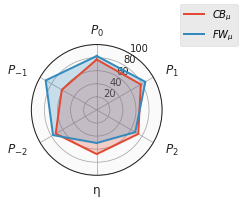

In [12]:
fig, ax = plot_plt_radar_comparison(
    [cb_values, fw_values], 
    fw_labels, 
    ['$CB_{\mu}$', '$FW_{\mu}$'],
    [POSITION_COLOR_DICT['CB'], POSITION_COLOR_DICT['FW']]
)
fig.savefig('cb_vs_fw_power_radar.png', dpi=300)

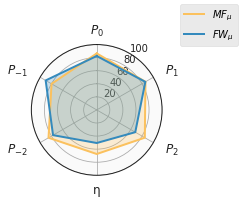

In [13]:
fig, ax = plot_plt_radar_comparison(
    [mf_values, fw_values], 
    fw_labels, 
    ['$MF_{\mu}$', '$FW_{\mu}$'],
    [POSITION_COLOR_DICT['MF'], POSITION_COLOR_DICT['FW']]
)
fig.savefig('mf_vs_fw_power_radar.png', dpi=300)

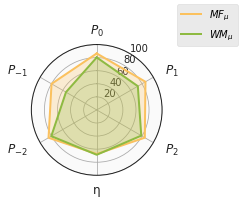

In [14]:
fig, ax = plot_plt_radar_comparison(
    [mf_values, wm_values], 
    wm_labels, 
    ['$MF_{\mu}$', '$WM_{\mu}$'],
    [POSITION_COLOR_DICT['MF'], POSITION_COLOR_DICT['WM']]
)
fig.savefig('mf_vs_wm_power_radar.png', dpi=300)

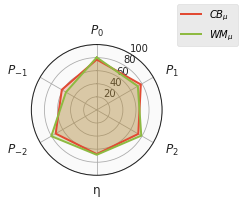

In [15]:
fig, ax = plot_plt_radar_comparison(
    [cb_values, wm_values], 
    cb_labels, 
    ['$CB_{\mu}$', '$WM_{\mu}$'],
    [POSITION_COLOR_DICT['CB'], POSITION_COLOR_DICT['WM']]
)
fig.savefig('cb_vs_wm_power_radar.png', dpi=300)

In [16]:
pso_df.loc[:, 'athlete_id'] = pso_df.player.apply(lambda r: r.split('athlete')[1])
pso_df.loc[:, 'athlete_id'] = pso_df.loc[:, 'athlete_id'].astype(int)
pso_df = pso_df.sort_values('athlete_id')
pso_df.reset_index(inplace=True, drop=True)
pso_df

,player,stamina,P-2,P-1,P0,P1,P2,position,num_players,athlete_id
0,athlete1,0.530647,600.748503,619.995720,698.806329,701.459223,705.743390,WM,1,1
1,athlete2,0.851097,602.882317,493.988125,591.605164,530.200323,539.021814,WM,1,2
2,athlete3,0.500000,676.651050,632.451701,698.871911,756.931823,689.383202,FW,1,3
3,athlete4,0.663839,459.265574,565.610941,665.691956,636.509247,622.844848,MF,1,4
4,athlete5,0.866737,561.715360,423.458018,534.429683,498.969543,469.488648,WM,1,5
5,athlete6,0.699258,748.520615,724.759580,688.941827,741.011152,800.000000,MF,1,6
6,athlete7,0.864999,600.018943,422.141596,545.902623,518.130167,570.280051,MF,1,7
7,athlete8,0.624298,702.722868,545.334568,640.337119,667.057442,614.168878,CB,1,8
8,athlete9,0.500000,800.000000,694.626460,744.693587,800.000000,437.290573,FW,1,9
9,athlete10,0.580299,800.000000,693.850882,782.337760,747.640559,603.532511,MF,1,10


In [17]:
wm_p = pso_df[pso_df.player == 'athlete2'].iloc[0]
fw_p = pso_df[pso_df.player == 'athlete3'].iloc[0]
wm_p2 = pso_df[pso_df.player == 'athlete1'].iloc[0]

In [18]:
labels_wm, values_wm = get_labels_and_values(wm_p)
labels_fw, values_fw = get_labels_and_values(fw_p)
labels_wm2, values_wm2 = get_labels_and_values(wm_p2)

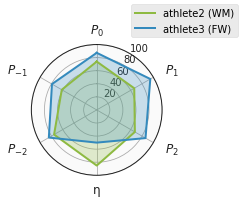

In [19]:
fig, ax = plot_plt_radar_comparison(
    [values_wm, values_fw], 
    labels_wm, 
    ['athlete2 (WM)', 'athlete3 (FW)'],
    [POSITION_COLOR_DICT['WM'], POSITION_COLOR_DICT['FW']]
)
fig.savefig('player_wm_vs_fw_power_radar.png', dpi=300)

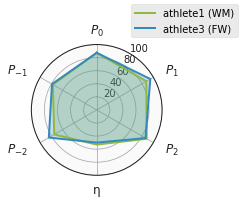

In [20]:
fig, ax = plot_plt_radar_comparison(
    [values_wm2, values_fw], 
    labels_wm, 
    ['athlete1 (WM)', 'athlete3 (FW)'],
    [POSITION_COLOR_DICT['WM'], POSITION_COLOR_DICT['FW']]
)
fig.savefig('player_wm_vs_fw_power_radar2.png', dpi=300)